In [96]:
source("/root/workspace/code/sc-transformer/preprocess/utils.R")
setwd("/root/workspace/code/sc-transformer/")
library(RColorBrewer)
library(patchwork)

parser <- ArgumentParser()
parser$add_argument("--task", type = "character", default = "dogma_single_full_transfer")
parser$add_argument("--method", type = "character", default = "midas_embed")
parser$add_argument("--experiment", type = "character", default = "e0")
parser$add_argument("--model", type = "character", default = "default")
parser$add_argument("--init_model", type = "character", default = "sp_00003699")
parser$add_argument("--load_saved", type = "logical", default = F)
o <- parser$parse_known_args()[[1]]

data_name <- strsplit(o$task, split = "_")[[1]][1]
config <- parseTOML("configs/data.toml")[[gsub("_transfer$|_ref_.*$", "", o$task)]]
subset_names <- basename(config$raw_data_dirs)
subset_ids <- sapply(seq_along(subset_names) - 1, toString)
input_dirs <- pj("result", o$task, o$experiment, o$model, "predict", o$init_model, paste0("subset_", subset_ids))
pp_dir <- pj("data", "processed", o$task)
output_dir <- pj("result", "comparison", o$task, o$method, o$experiment, o$init_model)
mkdir(output_dir, remove_old = F)
label_paths <- pj(config$raw_data_dirs, "label_seurat", "l1.csv")

K <- parseTOML("configs/model.toml")[["default"]]$dim_c
l <- 7.5  # figure size
L <- 10   # figure size
m <- 0.5  # legend margin

## Load preprossed data

In [97]:
z_joint_list <- list()
z_atac_list <- list()
z_rna_list <- list()
z_adt_list <- list()
cell_name_list <- list()
label_list <- list()
is_label <- T
subset_name_list <- list()
S <- length(subset_names)
for (i in seq_along(subset_names)) {
    subset_name <- subset_names[i]

    z_joint_dir <- pj(input_dirs[i], "z", "joint")
    fnames <- dir(path = z_joint_dir, pattern = ".csv$")
    fnames <- str_sort(fnames, decreasing = F)
    N <- length(fnames)
    z_joint_subset_list <- list()
    for (n in seq_along(fnames)) {
        message(paste0("Loading Subset ", i, "/", S, ", File ", n, "/", N))
        z_joint_subset_list[[n]] <- read.csv(file.path(z_joint_dir, fnames[n]), header = F)
    }
    z_joint_list[[subset_name]] <- bind_rows(z_joint_subset_list)

    z_atac_dir <- pj(input_dirs[i], "z", "atac")
    if (dir.exists(z_atac_dir)) {
        z_subset_atac_list <- list()
        for (n in seq_along(fnames)) {
            z_subset_atac_list[[n]] <- read.csv(file.path(z_atac_dir, fnames[n]), header = F)
        }
        z_atac_list[[subset_name]] <- bind_rows(z_subset_atac_list)
    }

    z_rna_dir  <- pj(input_dirs[i], "z", "rna")
    if (dir.exists(z_rna_dir)) {
        z_subset_rna_list <- list()
        for (n in seq_along(fnames)) {
            z_subset_rna_list[[n]] <- read.csv(file.path(z_rna_dir, fnames[n]), header = F)
        }
        z_rna_list[[subset_name]] <- bind_rows(z_subset_rna_list)
    }

    z_adt_dir  <- pj(input_dirs[i], "z", "adt")
    if (dir.exists(z_adt_dir)) {
        z_subset_adt_list <- list()
        for (n in seq_along(fnames)) {
            z_subset_adt_list[[n]] <- read.csv(file.path(z_adt_dir, fnames[n]), header = F)
        }
        z_adt_list[[subset_name]] <- bind_rows(z_subset_adt_list)
    }

    cell_name_list[[subset_name]] <- read.csv(pj(pp_dir, paste0("subset_", subset_ids[i]),
        "cell_names.csv"), header = T)[, 2]
    if (file.exists(label_paths[i])) {
        label_list[[subset_name]] <- read.csv(label_paths[i], header = T)[, 2]
    } else {
        is_label <- F
    }
    subset_name_list[[subset_name]] <- rep(subset_name, length(cell_name_list[[subset_name]]))
}

Loading Subset 1/4, File 1/29

Loading Subset 1/4, File 2/29

Loading Subset 1/4, File 3/29

Loading Subset 1/4, File 4/29

Loading Subset 1/4, File 5/29

Loading Subset 1/4, File 6/29

Loading Subset 1/4, File 7/29

Loading Subset 1/4, File 8/29

Loading Subset 1/4, File 9/29

Loading Subset 1/4, File 10/29

Loading Subset 1/4, File 11/29

Loading Subset 1/4, File 12/29

Loading Subset 1/4, File 13/29

Loading Subset 1/4, File 14/29

Loading Subset 1/4, File 15/29

Loading Subset 1/4, File 16/29

Loading Subset 1/4, File 17/29

Loading Subset 1/4, File 18/29

Loading Subset 1/4, File 19/29

Loading Subset 1/4, File 20/29

Loading Subset 1/4, File 21/29

Loading Subset 1/4, File 22/29

Loading Subset 1/4, File 23/29

Loading Subset 1/4, File 24/29

Loading Subset 1/4, File 25/29

Loading Subset 1/4, File 26/29

Loading Subset 1/4, File 27/29

Loading Subset 1/4, File 28/29

Loading Subset 1/4, File 29/29

Loading Subset 2/4, File 1/24

Loading Subset 2/4, File 2/24

Loading Subset 2/4,

## Create seurat objects

In [98]:
objs <- list()
if (length(z_atac_list) > 0) {
    counts <- t(data.matrix(bind_rows(z_atac_list))) * 0  # pseudo counts
    colnames(counts) <- do.call("c", unname(cell_name_list[names(z_atac_list)]))
    rownames(counts) <- paste0("feat-", seq_len(nrow(counts)))
    obj_atac <- CreateSeuratObject(counts = counts, assay = "joint")

    z <- data.matrix(bind_rows(z_atac_list))
    c <- z[, 1:K]
    colnames(c) <- paste0("c_", seq_len(ncol(c)))
    rownames(c) <- colnames(obj_atac)
    obj_atac[["c"]] <- CreateDimReducObject(embeddings = c, key = "c_", assay = "joint")

    u <- z[, (K+1):(K+2)]
    colnames(u) <- paste0("u_", seq_len(ncol(u)))
    rownames(u) <- colnames(obj_atac)
    obj_atac[["u"]] <- CreateDimReducObject(embeddings = u, key = "u_", assay = "joint")

    obj_atac@meta.data$batch <- factor(x = do.call("c", unname(subset_name_list[names(z_atac_list)])), levels = subset_names)
    table(obj_atac@meta.data$batch)[unique(obj_atac@meta.data$batch)]
    if (is_label) {
        obj_atac@meta.data$l1 <- do.call("c", unname(label_list[names(z_atac_list)]))
    } else {
        obj_atac@meta.data$l1 <- obj_atac@meta.data$batch
    }
    obj_atac@meta.data$mod <- "atac"
    obj_atac <- RenameCells(obj_atac, add.cell.id = "atac")

    obj_atac
    objs[["atac"]] <- obj_atac
}

In [99]:
if (length(z_rna_list) > 0) {
    counts <- t(data.matrix(bind_rows(z_rna_list))) * 0  # pseudo counts
    colnames(counts) <- do.call("c", unname(cell_name_list[names(z_rna_list)]))
    rownames(counts) <- paste0("feat-", seq_len(nrow(counts)))
    obj_rna <- CreateSeuratObject(counts = counts, assay = "joint")

    z <- data.matrix(bind_rows(z_rna_list))
    c <- z[, 1:K]
    colnames(c) <- paste0("c_", seq_len(ncol(c)))
    rownames(c) <- colnames(obj_rna)
    obj_rna[["c"]] <- CreateDimReducObject(embeddings = c, key = "c_", assay = "joint")

    u <- z[, (K+1):(K+2)]
    colnames(u) <- paste0("u_", seq_len(ncol(u)))
    rownames(u) <- colnames(obj_rna)
    obj_rna[["u"]] <- CreateDimReducObject(embeddings = u, key = "u_", assay = "joint")

    obj_rna@meta.data$batch <- factor(x = do.call("c", unname(subset_name_list[names(z_rna_list)])), levels = subset_names)
    table(obj_rna@meta.data$batch)[unique(obj_rna@meta.data$batch)]
    if (is_label) {
        obj_rna@meta.data$l1 <- do.call("c", unname(label_list[names(z_rna_list)]))
    } else {
        obj_rna@meta.data$l1 <- obj_rna@meta.data$batch
    }
    obj_rna@meta.data$mod <- "rna"
    obj_rna <- RenameCells(obj_rna, add.cell.id = "rna")

    obj_rna
    objs[["rna"]] <- obj_rna
}

In [100]:
if (length(z_adt_list) > 0) {
    counts <- t(data.matrix(bind_rows(z_adt_list))) * 0  # pseudo counts
    colnames(counts) <- do.call("c", unname(cell_name_list[names(z_adt_list)]))
    rownames(counts) <- paste0("feat-", seq_len(nrow(counts)))
    obj_adt <- CreateSeuratObject(counts = counts, assay = "joint")

    z <- data.matrix(bind_rows(z_adt_list))
    c <- z[, 1:K]
    colnames(c) <- paste0("c_", seq_len(ncol(c)))
    rownames(c) <- colnames(obj_adt)
    obj_adt[["c"]] <- CreateDimReducObject(embeddings = c, key = "c_", assay = "joint")

    u <- z[, (K+1):(K+2)]
    colnames(u) <- paste0("u_", seq_len(ncol(u)))
    rownames(u) <- colnames(obj_adt)
    obj_adt[["u"]] <- CreateDimReducObject(embeddings = u, key = "u_", assay = "joint")

    obj_adt@meta.data$batch <- factor(x = do.call("c", unname(subset_name_list[names(z_adt_list)])), levels = subset_names)
    table(obj_adt@meta.data$batch)[unique(obj_adt@meta.data$batch)]
    if (is_label) {
        obj_adt@meta.data$l1 <- do.call("c", unname(label_list[names(z_adt_list)]))
    } else {
        obj_adt@meta.data$l1 <- obj_adt@meta.data$batch
    }
    obj_adt@meta.data$mod <- "adt"
    obj_adt <- RenameCells(obj_adt, add.cell.id = "adt")

    obj_adt
    objs[["adt"]] <- obj_adt
}

In [101]:
counts <- t(data.matrix(bind_rows(z_joint_list))) * 0  # pseudo counts
colnames(counts) <- do.call("c", unname(cell_name_list))
rownames(counts) <- paste0("feat-", seq_len(nrow(counts)))
obj_joint <- CreateSeuratObject(counts = counts, assay = "joint")

z <- data.matrix(bind_rows(z_joint_list))
c <- z[, 1:K]
colnames(c) <- paste0("c_", seq_len(ncol(c)))
rownames(c) <- colnames(obj_joint)
obj_joint[["c"]] <- CreateDimReducObject(embeddings = c, key = "c_", assay = "joint")

u <- z[, (K+1):(K+2)]
colnames(u) <- paste0("u_", seq_len(ncol(u)))
rownames(u) <- colnames(obj_joint)
obj_joint[["u"]] <- CreateDimReducObject(embeddings = u, key = "u_", assay = "joint")

obj_joint@meta.data$batch <- factor(x = do.call("c", unname(subset_name_list)), levels = subset_names)
table(obj_joint@meta.data$batch)[unique(obj_joint@meta.data$batch)]
if (is_label) {
    obj_joint@meta.data$l1 <- do.call("c", unname(label_list))
} else {
    obj_joint@meta.data$l1 <- obj_joint@meta.data$batch
}
obj_joint@meta.data$mod <- "joint"
obj_joint <- RenameCells(obj_joint, add.cell.id = "joint")

obj_joint
objs[["joint"]] <- obj_joint


lll_ctrl lll_stim dig_ctrl dig_stim 
    7361     5897    10190     9527 

An object of class Seurat 
34 features across 32975 samples within 1 assay 
Active assay: joint (34 features, 0 variable features)
 2 dimensional reductions calculated: c, u

In [102]:
if (o$load_saved) {
    obj_merged <- LoadH5Seurat(pj(output_dir, "obj_vis.h5seurat"), reductions = c("cUMAP", "uUMAP"))
} else {
    obj_merged <- merge(objs[[1]], y = unlist(objs[-1]), merge.dr = c("c", "u"))
    obj_merged@meta.data$mod <- factor(x = obj_merged@meta.data$mod, levels = names(objs))
    obj_merged
    obj_merged <- RunUMAP(obj_merged, reduction = "c", dims = 1:K, reduction.name = "cUMAP")
    obj_merged <- RunUMAP(obj_merged, reduction = "u", dims = 1:2, metric = "euclidean", reduction.name = "uUMAP")
    SaveH5Seurat(obj_merged, pj(output_dir, "obj_vis.h5seurat"), overwrite = T)
}

obj_mod <- SplitObject(obj_merged, split.by = "mod")
obj <- lapply(obj_mod, SplitObject, split.by = "batch")

## Visualization

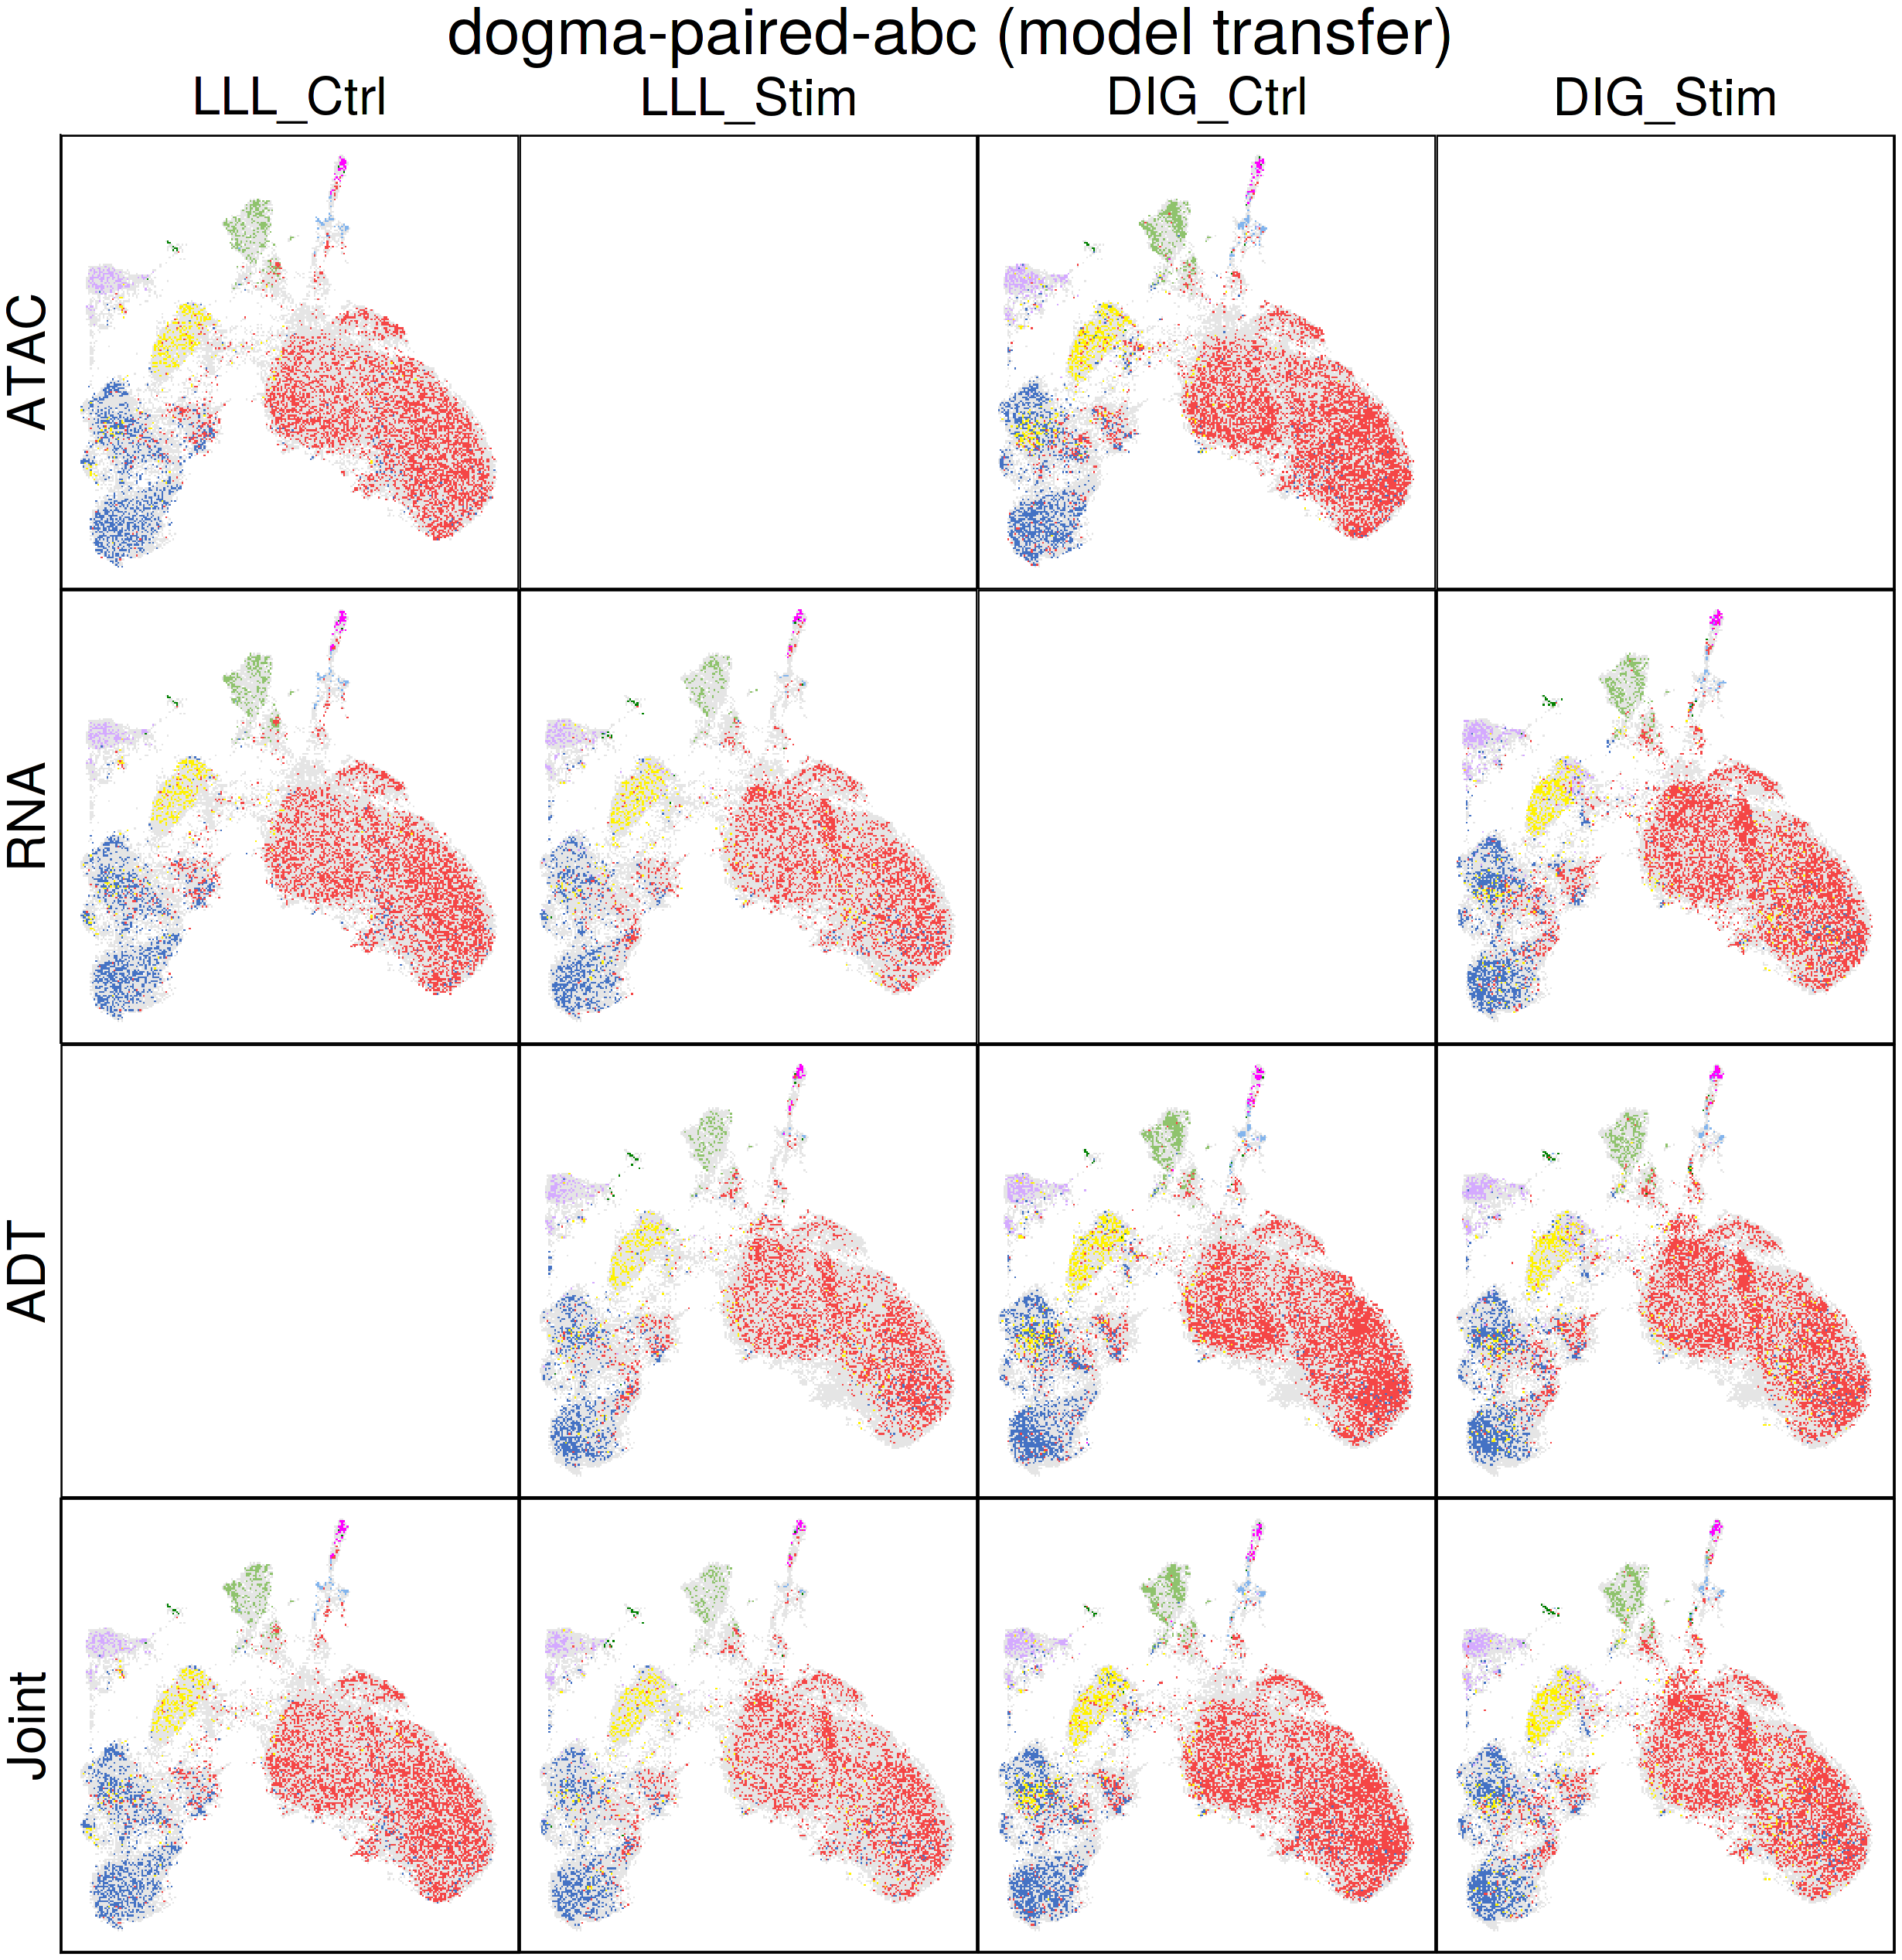

In [107]:
pal <- col_8
labels <- str_sort(unique(obj_merged@meta.data$l1))
label_to_color <- list()
for (i in seq_along(labels)) {
    label_to_color[[labels[i]]] <- pal[i]
}
order <- c(str_sort(unique(obj_merged@meta.data$l1), decreasing = T), "Unselected")
plt <- NULL
for (m in names(objs)) {
    subsets <- names(obj[[m]])
    for (s in subset_names) {
        if (s %in% subsets) {
            # set groups for highlighting
            obj_merged@meta.data$highlight <- "Unselected"
            select_mask <- colnames(obj_merged) %in% colnames(obj[[m]][[s]])
            obj_merged@meta.data$highlight[select_mask] <- obj_merged@meta.data$l1[select_mask]
            # set label-specific colors
            cols <- c("#E5E5E5")
            for (label in str_sort(unique(obj[[m]][[s]]@meta.data$l1))) {
                cols <- c(cols, label_to_color[[label]])
            }
            # plot
            p <- DimPlot(obj_merged, reduction = "cUMAP", group.by = "highlight", repel = T,
                #  label.size = 4, pt.size = 0.1, shuffle = F, cols = cols, order = order, raster = F)
                 label.size = 4, pt.size = 0.1, shuffle = F, cols = cols, order = order, raster = T, raster.dpi = c(250, 250))
        } else {
            # p <- plot_spacer()
            p <- ggplot()# + theme_void()
        }

        if (m == "atac") {
            s_ <- gsub("lll", "LLL", gsub("dig", "DIG", gsub("ctrl", "Ctrl", gsub("stim", "Stim", s))))
            p <- p + ggtitle(s_) + theme(plot.title = element_text(face = "plain", hjust = 0.5, size = 40))
        } else {
            p <- p + theme(plot.title = element_blank())
        }

        if (data_name == "dogma" & s == "lll_ctrl" | data_name == "teadog" & s == "w1") {
            p <- p + theme(axis.title.y = element_text(size = 40),
                           axis.title.x = element_blank(),
                           axis.text.x = element_blank(),
                           axis.text.y = element_blank(),
                           axis.ticks.x = element_blank(),
                           axis.ticks.y = element_blank()) + labs(y = gsub("JOINT", "Joint", toupper(m)))
        } else {
            p <- p + NoAxes()
        }

        p <- p + NoLegend() +
            theme(panel.border = element_rect(color = "black", size = 1),
            axis.ticks.length = unit(0, "pt"), plot.margin = margin(0, 0, 0, 0)) +
            labs(colour = "Cell type")

        if (!is_label) {
            p <- p + NoLegend()
        }

        if (is.null(plt)) {
            plt <- p
        } else {
            plt <- plt + p
        }
    }
}
# plt <- plt + plot_layout(nrow = length(objs), guides = "collect") +
#        plot_annotation(title = rename_task(o$task),
#                        theme = theme(plot.title = element_text(size = 50, hjust = 0.5))
#                       ) & theme(legend.position = "right")
plt <- plt + plot_layout(nrow = length(objs)) +
       plot_annotation(title = rename_task(o$task),
                       theme = theme(plot.title = element_text(size = 50, hjust = 0.5))
                      )

w <- 5 * S + 0.5
h <- 5 * length(objs) + 0.5 + 0.625
plt_size(w, h)
plt
save_path <- pj(output_dir, paste(o$task, o$method, o$experiment, o$init_model, "c_all", sep = "_"))
ggsave(plot = plt, file = paste0(save_path, ".png"), width = w, height = h, limitsize = F)
ggsave(plot = plt, file = paste0(save_path, ".pdf"), width = w, height = h, limitsize = F)

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will rep

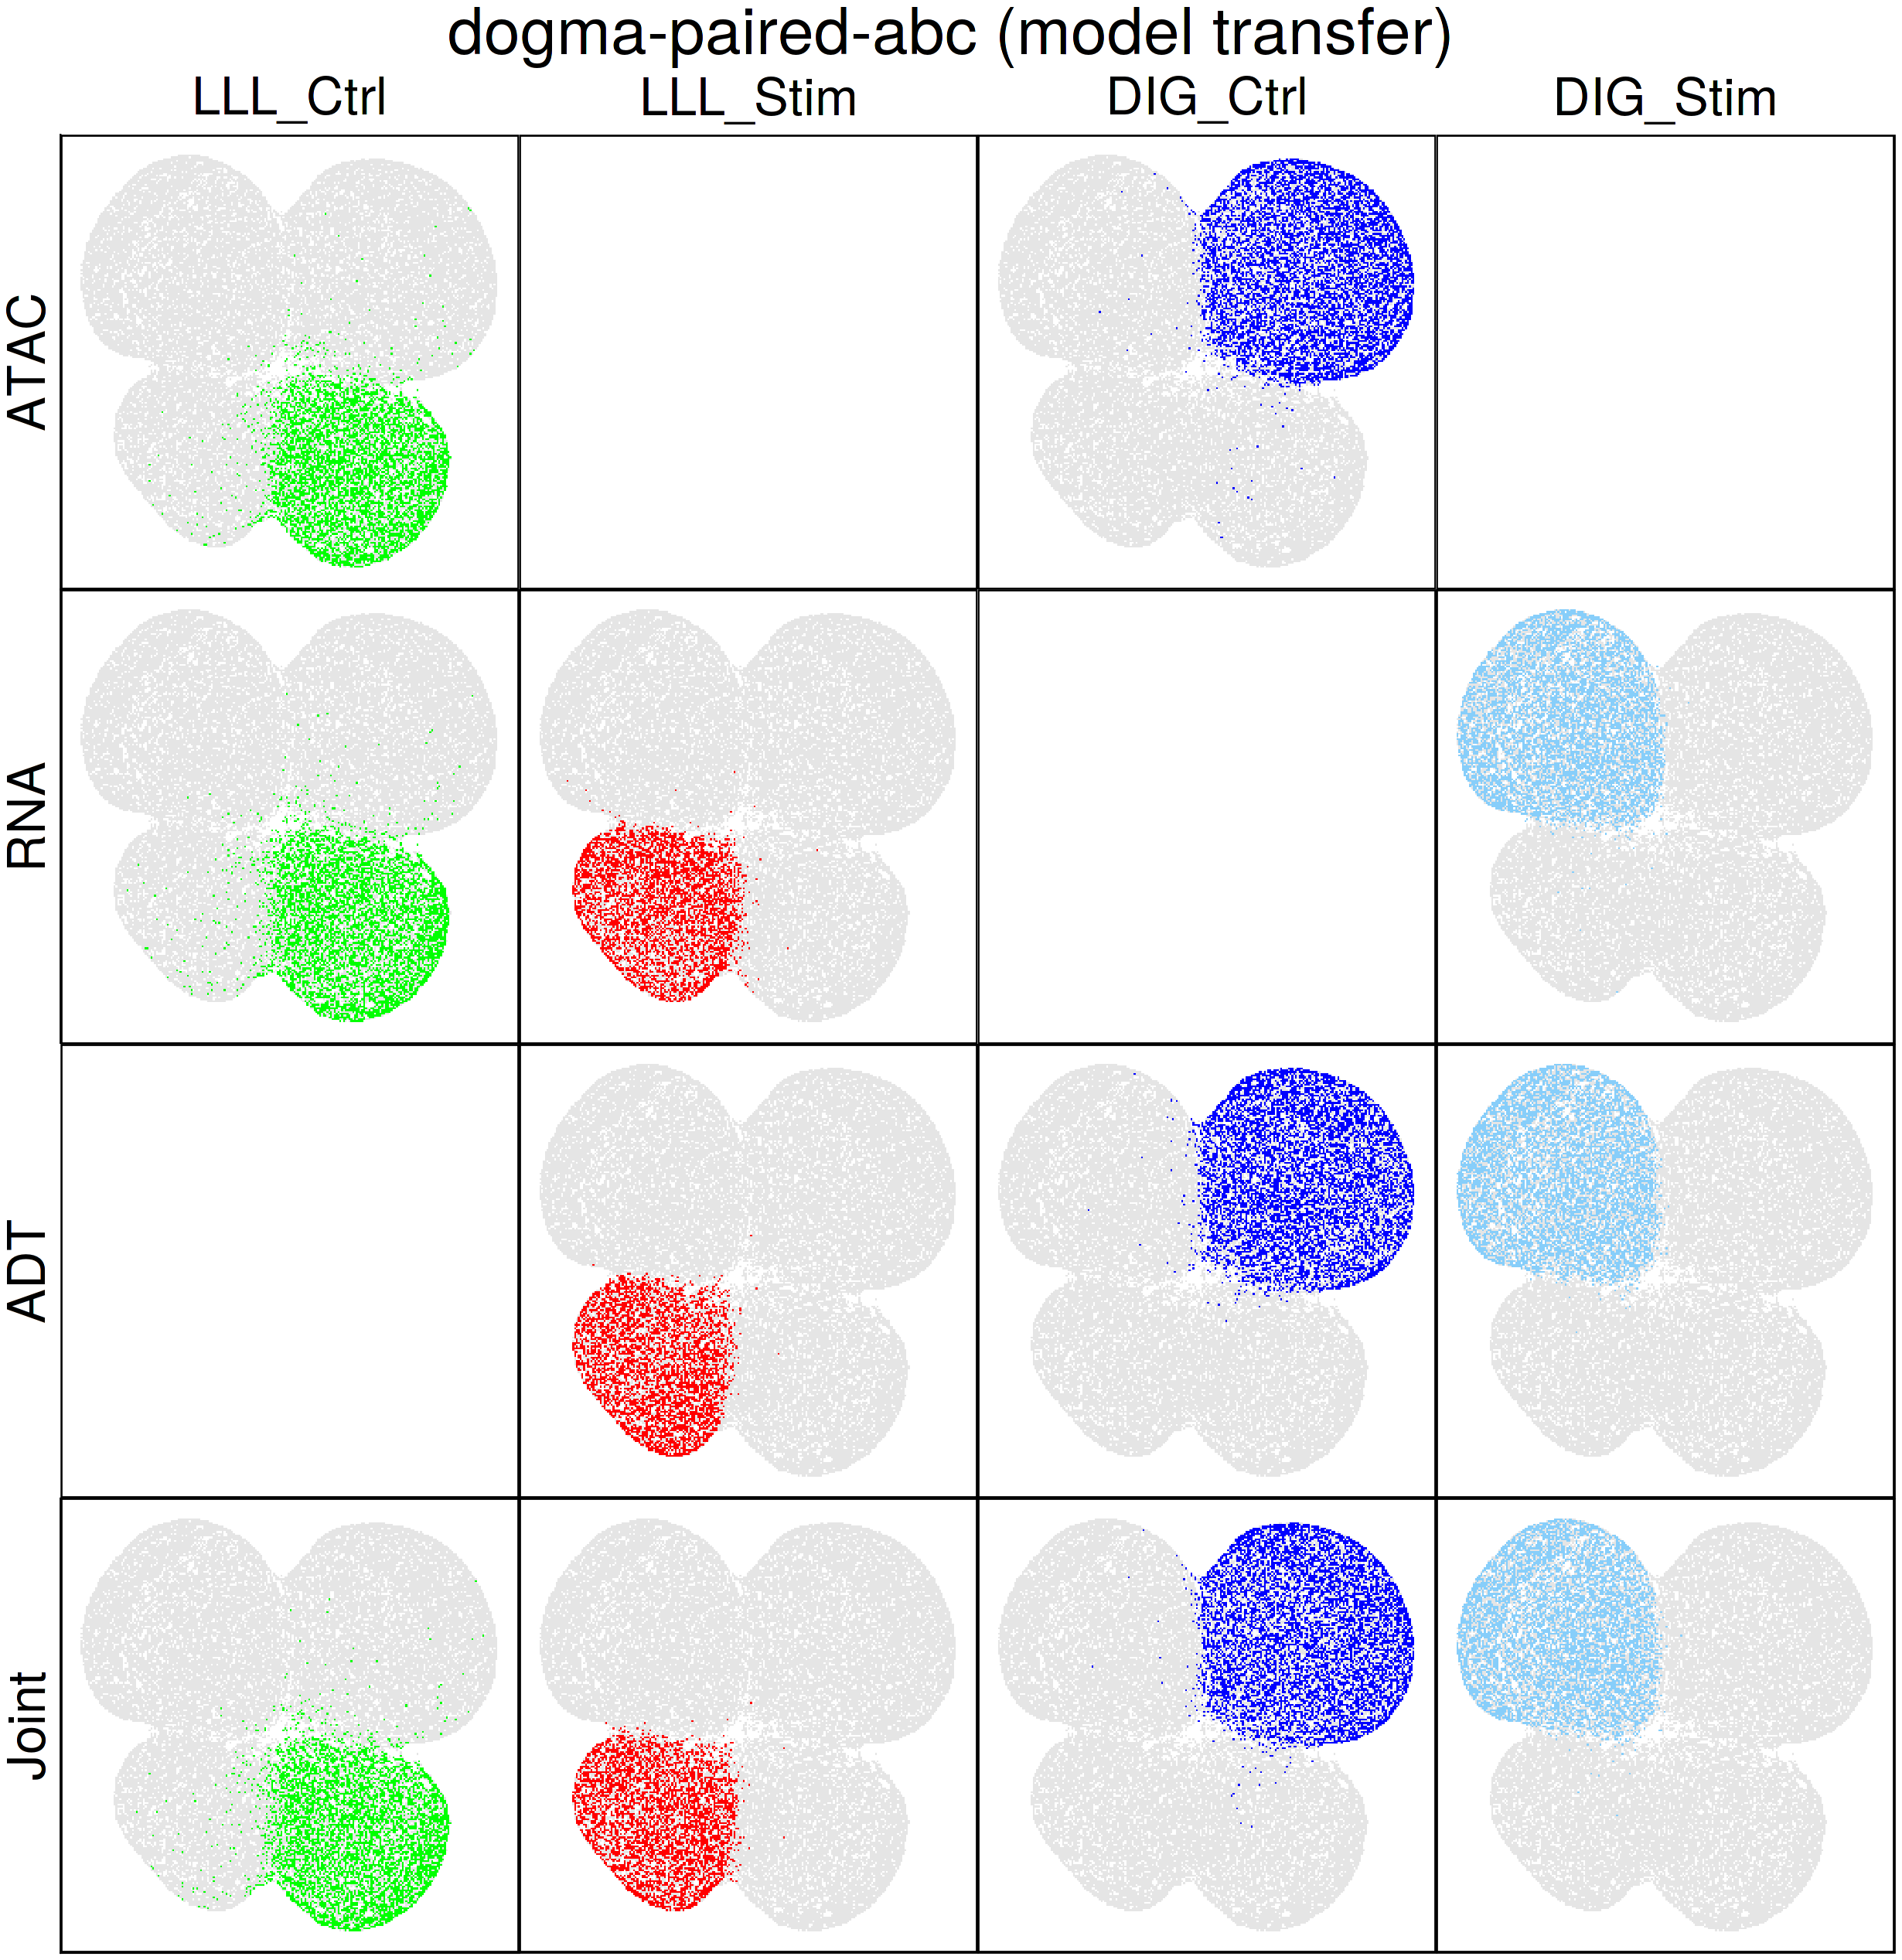

In [108]:
pal <- col_4
cols <- c("#E5E5E5", pal)
order <- c(rev(subset_names), "Unselected")
plt <- NULL
for (m in names(objs)) {
    subsets <- names(obj[[m]])
    for (s in subset_names) {
        if (s %in% subsets) {
            # set groups for highlighting
            obj_merged@meta.data$highlight <- "Unselected"
            select_mask <- colnames(obj_merged) %in% colnames(obj[[m]][[s]])
            obj_merged@meta.data$highlight[select_mask] <- obj_merged@meta.data$batch[select_mask]
            # plot
            p <- DimPlot(obj_merged, reduction = "uUMAP", group.by = "highlight", repel = T,
                 label.size = 4, pt.size = 0.1, shuffle = F, cols = cols, order = order, raster = T, raster.dpi = c(250, 250))
        } else {
            # p <- plot_spacer()
            p <- ggplot()# + theme_void()
        }

        if (m == "atac") {
            s_ <- gsub("lll", "LLL", gsub("dig", "DIG", gsub("ctrl", "Ctrl", gsub("stim", "Stim", s))))
            p <- p + ggtitle(s_) + theme(plot.title = element_text(face = "plain", hjust = 0.5, size = 40))
        } else {
            p <- p + theme(plot.title = element_blank())
        }

        if (data_name == "dogma" & s == "lll_ctrl" | data_name == "teadog" & s == "w1") {
            p <- p + theme(axis.title.y = element_text(size = 40),
                           axis.title.x = element_blank(),
                           axis.text.x = element_blank(),
                           axis.text.y = element_blank(),
                           axis.ticks.x = element_blank(),
                           axis.ticks.y = element_blank()) + labs(y = gsub("JOINT", "Joint", toupper(m)))
        } else {
            p <- p + NoAxes()
        }

        p <- p  + NoLegend() + 
            theme(panel.border = element_rect(color = "black", size = 1),
            axis.ticks.length = unit(0, "pt"), plot.margin = margin(0, 0, 0, 0)) +
            scale_colour_manual(values = cols, drop = FALSE) +
            labs(colour = "Sample")

        if (!is_label) {
            p <- p + NoLegend()
        }

        if (is.null(plt)) {
            plt <- p
        } else {
            plt <- plt + p
        }
    }
}
# plt <- plt + plot_layout(nrow = length(objs), guides = "collect") +
#        plot_annotation(title = rename_task(o$task),
#                        theme = theme(plot.title = element_text(size = 50, hjust = 0.5))
#                       ) & theme(legend.position = "right")
plt <- plt + plot_layout(nrow = length(objs)) +
       plot_annotation(title = rename_task(o$task),
                       theme = theme(plot.title = element_text(size = 50, hjust = 0.5))
                      )

w <- 5 * S + 0.5
h <- 5 * length(objs) + 0.5 + 0.625
plt_size(w, h)
plt
save_path <- pj(output_dir, paste(o$task, o$method, o$experiment, o$init_model, "u_all", sep = "_"))
ggsave(plot = plt, file = paste0(save_path, ".png"), width = w, height = h, limitsize = F)
ggsave(plot = plt, file = paste0(save_path, ".pdf"), width = w, height = h, limitsize = F)
